In [1]:
# !pip install numpy pandas librosa soundfile matplotlib scikit-learn tensorflow==2.15.0 sounddevice==0.4.6

import os, json, math, time, sys, uuid
from dataclasses import dataclass
from typing import Optional, Tuple, List

import numpy as np
import pandas as pd
import soundfile as sf
import librosa

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
from IPython.display import Audio, display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [36]:
# -------------------
# Global config
# -------------------
CSV_PATH      = "../labels_export.csv"   # pas aan naar jouw pad
# ROOT_AUDIO wijst nu naar een lijst van folders waar gezocht wordt naar audio-bestanden
ROOT_AUDIO = ["../data/coughing/", "../data/heartsounds/"]

# audio/feature
TARGET_SR: int = 16000                 # jouw opnames zijn 15750/16000 -> resample naar 16000
FRAME_LEN_S: float = 3.0               # vaste duur per sample (pad/crop)
N_FFT: int = 1024
HOP: int  = 256
WIN: int  = 1024                       # zelfde als N_FFT (Hann)
FMIN: int = 20
FMAX: Optional[int] = None             # None => sr/2
TOP_DB: float = 80.0                   # voor visualisatie/normalisatie

# afgeleide dims (géén center, zodat shapes deterministisch zijn)
FRAME_LEN_SAMPLES = int(round(FRAME_LEN_S * TARGET_SR))
F_BINS = 1 + N_FFT // 2
T_BINS = 1 + max(0, (FRAME_LEN_SAMPLES - N_FFT)) // HOP

print("Expected STFT shape (F,T):", F_BINS, T_BINS)

Expected STFT shape (F,T): 513 184


In [37]:
df = pd.read_csv(CSV_PATH)
print(df.head(3))
print("\nKolommen:", list(df.columns))

         date                             filename  t_start  t_end  label  \
0  2025-09-29  coughing/new_microphone/cough_1.wav     1.68   4.68  Hoest   
1  2025-09-29  coughing/new_microphone/cough_1.wav     6.80   9.80  Hoest   
2  2025-09-29  coughing/new_microphone/cough_1.wav    11.93  14.93  Hoest   

  gender  age  location  
0    NaN  NaN       NaN  
1    NaN  NaN       NaN  
2    NaN  NaN       NaN  

Kolommen: ['date', 'filename', 't_start', 't_end', 'label', 'gender', 'age', 'location']


In [38]:
# label_primary afleiden: eerste token (split op ';'), trimmen
def to_primary_label(s: str) -> str:
    if not isinstance(s, str) or s.strip() == "":
        return "Onbekend"
    tok = s.split(";")[0].strip()
    return tok if tok else "Onbekend"

df["label_primary"] = df["label"].apply(to_primary_label)

# Eventueel filteren op 2 klassen (bijv. 'Hoest' vs 'Normaal'); laat lege weg
# Als je ALLES wilt houden, comment de volgende 2 regels uit
keep = df["label_primary"].isin(["Hoest", "Normaal", "Hart"])
df = df[keep].reset_index(drop=True)

print(df["label_primary"].value_counts())
print(len(df), "segment-rijen")

label_primary
Hart       200
Normaal    115
Hoest       54
Name: count, dtype: int64
369 segment-rijen


In [42]:
def load_audio_full(rel_path: str, target_sr: int) -> np.ndarray:
    """Laad een WAV (mono) en resample naar target_sr.
    Werkt met ROOT_AUDIO als str of als list van root-folders."""
    import os
    from pathlib import Path

    # 1) Als rel_path al een absoluut pad is en bestaat -> direct gebruiken
    p = Path(rel_path)
    if p.is_absolute() and p.exists():
        path = str(p)
    else:
        # 2) Anders zoeken onder ROOT_AUDIO
        if isinstance(ROOT_AUDIO, (list, tuple)):
            path = None
            rel_p = Path(rel_path)
            rel_parts = rel_p.parts
            for root in ROOT_AUDIO:
                root_p = Path(root)
                # 1) root / rel_path (zoals eerder)
                cand = root_p / rel_p
                if cand.exists():
                    path = str(cand)
                    break
                # 2) Als de eerste map van rel gelijk is aan de laatste map van root (bv. coughing),
                #    probeer zonder die eerste map (voorkomt 'coughing/coughing/...').
                if rel_parts and root_p.name == rel_parts[0]:
                    cand2 = root_p / Path(*rel_parts[1:])
                    if cand2.exists():
                        path = str(cand2)
                        break
                # 3) Probeer ook vanuit de parent van root (bv. ../data/ + rel_path)
                cand3 = root_p.parent / rel_p
                if cand3.exists():
                    path = str(cand3)
                    break
                # 4) Fallback: enkel bestandsnaam
                cand4 = root_p / rel_p.name
                if cand4.exists():
                    path = str(cand4)
                    break

            if path is None:
                raise FileNotFoundError(f"Bestand niet gevonden voor '{rel_path}' in ROOT_AUDIO={ROOT_AUDIO}")
    y, sr = sf.read(path, dtype="float32", always_2d=False)
    if y.ndim == 2:
        y = y.mean(axis=1)
    if sr != target_sr:
        # Simpele bandbeperkte up/downsample met lineaire interpolatie (geen extra deps)
        import numpy as np
        n_new = int(round(len(y) * float(target_sr) / float(sr)))
        if n_new <= 1 or len(y) <= 1:
            y = np.zeros(max(n_new, 1), dtype=np.float32)
        else:
            x_old = np.arange(len(y), dtype=np.float64)
            x_new = np.linspace(0.0, len(y) - 1.0, n_new, dtype=np.float64)
            y = np.interp(x_new, x_old, y).astype(np.float32)
        sr = target_sr
    return y

def fix_segment_bounds(t0: float, t1: float, dur: float, frame_len_s: float, tol: float = 1e-3) -> Tuple[float, float]:
    """
    Zorg dat elk segment exact 'frame_len_s' duurt.
    - Als (t1 - t0) ≈ frame_len_s -> OK (snappen op 2 dec)
    - Als te kort/te lang: maak het precies frame_len_s door end = start + frame_len_s
      en schuif naar links als we over het einde komen.
    """
    t0 = float(t0); t1 = float(t1)
    want = float(frame_len_s)
    have = t1 - t0

    if abs(have - want) <= tol:
        a = round(max(0.0, min(t0, max(0.0, dur - want))), 2)
        b = round(min(dur, a + want), 2)
        return a, b

    # maak exact frame_len_s
    a = t0
    b = a + want
    if b > dur:
        a = max(0.0, dur - want)
        b = a + want
    return round(a, 2), round(b, 2)

def load_audio_segment(rel_path: str, t0: float, t1: float, target_sr: int, ensure_len: bool = True) -> np.ndarray:
    """Knip segment [t0, t1) uit bestand en resample. Pad of crop naar FRAME_LEN_SAMPLES indien nodig."""
    y_full = load_audio_full(rel_path, target_sr)
    dur = len(y_full) / target_sr
    if ensure_len:
        t0, t1 = fix_segment_bounds(t0, t1, dur, FRAME_LEN_S)

    a = int(round(t0 * target_sr))
    b = int(round(t1 * target_sr))
    a = max(0, min(a, len(y_full)))
    b = max(0, min(b, len(y_full)))
    y = y_full[a:b]

    # pad/crop naar exacte lengte in samples
    if len(y) < FRAME_LEN_SAMPLES:
        y = np.pad(y, (0, FRAME_LEN_SAMPLES - len(y)))
    elif len(y) > FRAME_LEN_SAMPLES:
        y = y[:FRAME_LEN_SAMPLES]
    return y.astype(np.float32)

# simpele pre-emphasis (ruisonderdruk / hoogfrequent detail accentueren)
def pre_emphasis(y: np.ndarray, coef: float = 0.97) -> np.ndarray:
    if len(y) < 2:
        return y
    out = np.empty_like(y)
    out[0] = y[0]
    out[1:] = y[1:] - coef * y[:-1]
    return out

def compute_stft_db(y: np.ndarray, sr: int, n_fft: int = N_FFT, hop: int = HOP,
                    win: int = WIN, center: bool = False) -> np.ndarray:
    """
    |Y| in dB met max=0dB (genormaliseerd per segment).
    Output shape: (F_BINS, T) waar F_BINS = 1 + n_fft//2.
    """
    # optioneel: denoise/pre-emphasis
    y = pre_emphasis(y)

    # STFT
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop, win_length=win,
                     window="hann", center=center)
    mag = np.abs(S).astype(np.float32)

    # normaliseer naar max==1
    mmax = mag.max() if mag.size else 1.0
    if mmax <= 1e-12:
        mmax = 1.0
    mag = mag / mmax

    S_db = 20.0 * np.log10(np.maximum(mag, 1e-6))  # in [-120, 0]
    return S_db

def fix_time_bins_stft(S_db: np.ndarray, t_bins: int = T_BINS) -> np.ndarray:
    """Pad of crop de tijd-as van het STFT dB-beeld naar t_bins."""
    F, T = S_db.shape
    if T < t_bins:
        pad = np.full((F, t_bins - T), -120.0, dtype=np.float32)
        S_db = np.concatenate([S_db, pad], axis=1)
    elif T > t_bins:
        S_db = S_db[:, :t_bins]
    return S_db

def spectrogram_to_01(S_db: np.ndarray, top_db: float = TOP_DB) -> np.ndarray:
    """
    Map dB [-top_db, 0] → [0,1].
    Alles < -top_db wordt op 0 gezet.
    """
    S_clipped = np.clip(S_db, -top_db, 0.0)
    return (S_clipped + top_db) / top_db

In [43]:
# Controleer en corrigeer segmentlengtes if needed; laat aantal correcties zien
def check_and_fix_lengths(df_segments: pd.DataFrame) -> pd.DataFrame:
    fixed = 0
    rows = []
    for _, row in df_segments.iterrows():
        rel = row["filename"]
        dur_s = len(load_audio_full(rel, TARGET_SR)) / TARGET_SR
        a, b = float(row["t_start"]), float(row["t_end"])
        a2, b2 = fix_segment_bounds(a, b, dur_s, FRAME_LEN_S)
        if abs((b - a) - FRAME_LEN_S) > 1e-3 or abs(a - a2) > 1e-6 or abs(b - b2) > 1e-6:
            fixed += 1
        row = row.copy()
        row["t_start"] = a2
        row["t_end"]   = b2
        rows.append(row)
    print(f"Segments fixed/normalized: {fixed} / {len(df_segments)}")
    return pd.DataFrame(rows)

df_segments = check_and_fix_lengths(df.copy())
df_segments.head(3)

Segments fixed/normalized: 43 / 369


,date,filename,t_start,t_end,label,gender,age,location,label_primary
0,2025-09-29,coughing/new_microphone/cough_1.wav,1.68,4.68,Hoest,NaN,NaN,NaN,Hoest
1,2025-09-29,coughing/new_microphone/cough_1.wav,6.80,9.80,Hoest,NaN,NaN,NaN,Hoest
2,2025-09-29,coughing/new_microphone/cough_1.wav,11.93,14.93,Hoest,NaN,NaN,NaN,Hoest


In [44]:
df_segments = df_segments.drop(columns=["gender", "age", "location"])
df_segments.head(3)

,date,filename,t_start,t_end,label,label_primary
0,2025-09-29,coughing/new_microphone/cough_1.wav,1.68,4.68,Hoest,Hoest
1,2025-09-29,coughing/new_microphone/cough_1.wav,6.80,9.80,Hoest,Hoest
2,2025-09-29,coughing/new_microphone/cough_1.wav,11.93,14.93,Hoest,Hoest


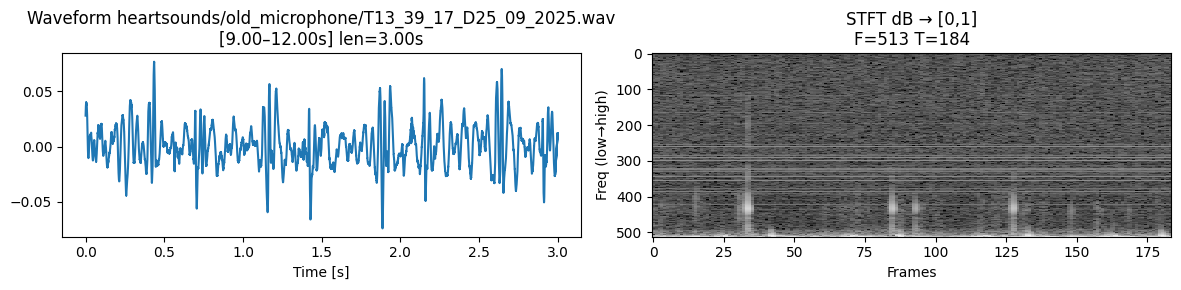

In [49]:
def preview_segment(row, sr=TARGET_SR):
    rel = row["filename"]
    a, b = float(row["t_start"]), float(row["t_end"])
    y = load_audio_segment(rel, a, b, sr)

    # plot waveform
    t = np.arange(len(y)) / sr
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    ax[0].plot(t, y)
    ax[0].set_title(f"Waveform {rel}\n[{a:.2f}–{b:.2f}s] len={len(y)/sr:.2f}s")
    ax[0].set_xlabel("Time [s]")

    # stft
    S_db = compute_stft_db(y, sr, N_FFT, HOP, WIN, center=False)
    S_db = fix_time_bins_stft(S_db, T_BINS)
    img = spectrogram_to_01(S_db, TOP_DB)

    ax[1].imshow(img[::-1, :], aspect="auto", interpolation="nearest", cmap="gray")
    ax[1].set_title(f"STFT dB → [0,1]\nF={img.shape[0]} T={img.shape[1]}")
    ax[1].set_xlabel("Frames"); ax[1].set_ylabel("Freq (low→high)")

    plt.tight_layout()
    plt.show()

    # playback
    display(Audio(y, rate=sr))

# Kies een willekeurig segment
preview_segment(df_segments.sample(1, random_state=1).iloc[0])

Oud playback bestand: coughing/old_microphone/cough_5.wav


Nieuw playback bestand: coughing/new_microphone/cough_5.wav


Oud playback bestand: coughing/old_microphone/cough_5.wav


Nieuw playback bestand: coughing/new_microphone/cough_3.wav


Oud playback bestand: coughing/old_microphone/cough_1.wav


Nieuw playback bestand: coughing/new_microphone/cough_4.wav


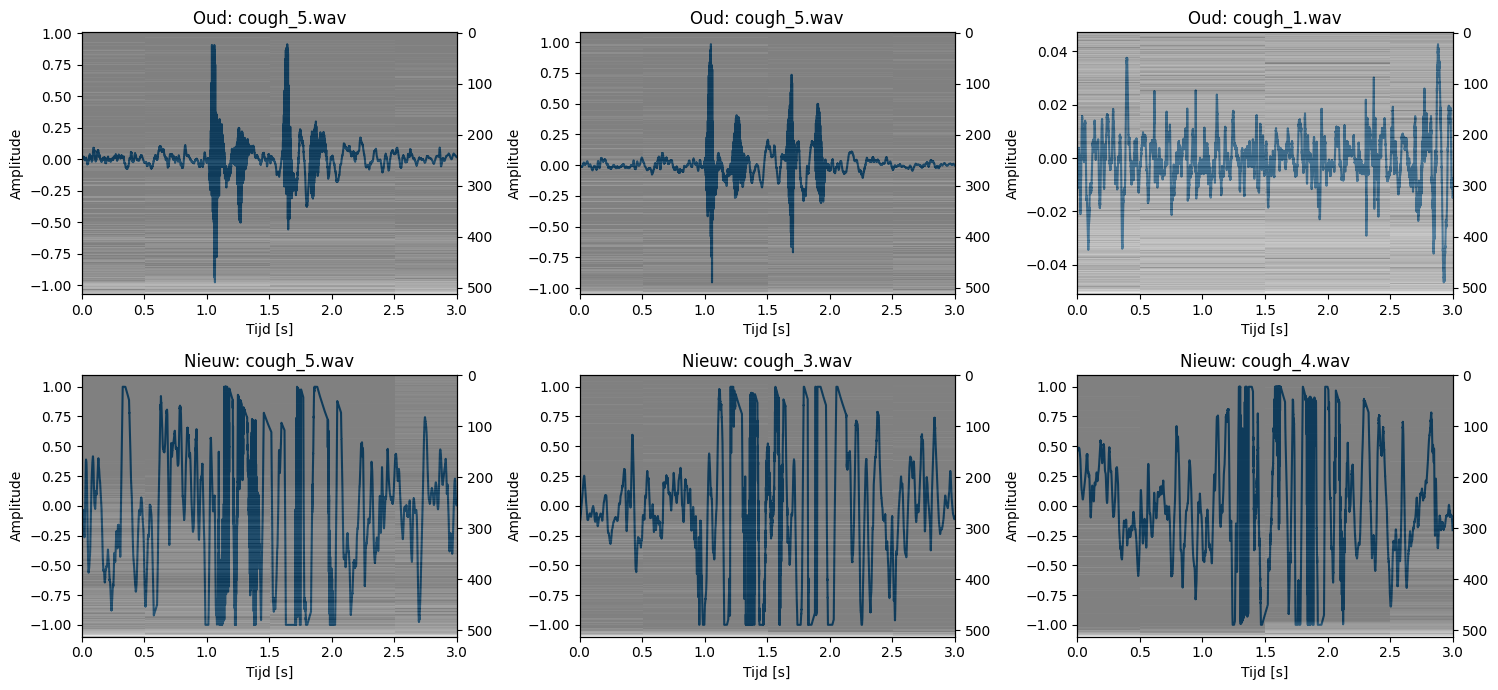

In [ ]:
6

In [ ]:
# 1) Label-normalisatie (zodat varianten als 'cough', 'normal', 'heart' ook werken)
def _norm_label(x: str) -> str:
    x = str(x).strip().lower()
    if x in {"hoest","cough"}:    return "Hoest"
    if x in {"normaal","normal"}: return "Normaal"
    if x in {"hart","heart"}:     return "Hart"
    return x  # laat anders zoals het is (maar waarschuwing)

df_segments = df.copy()
df_segments["label_primary_norm"] = df_segments["label_primary"].map(_norm_label)

In [62]:
df_segments['label_primary_norm'].value_counts()

label_primary_norm
Hart       200
Normaal    115
Hoest       54
Name: count, dtype: int64

In [63]:
# 2) Definieer de drie binaire experimenten
experiments = [
    ("Hoest vs Normaal", ("Hoest", "Normaal")),
    ("Hoest vs Hart",    ("Hoest", "Hart")),
    ("Normaal vs Hart",  ("Normaal", "Hart")),
]

In [69]:
input_shape = (F_BINS, T_BINS, 1)

def build_cnn(num_classes: int) -> keras.Model:
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [70]:
# 4) Herbruikbare training/evaluatie per experiment
def run_experiment(title: str, classes_pair: tuple[str, str]):
    input_shape = (F_BINS, T_BINS, 1)
    cls_a, cls_b = classes_pair
    print("\n" + "="*80)
    print(f"EXPERIMENT: {title}  —  Klassen: {cls_a} vs {cls_b}")

    # Filter alleen de twee gewenste klassen
    df_bin = df_segments[df_segments["label_primary_norm"].isin(classes_pair)].copy()
    if df_bin.empty:
        print("Geen data voor deze klassencombinatie; overslaan.")
        return

    # LabelEncoder fitten op exact deze twee klassen (volgorde behouden)
    le = LabelEncoder()
    le.fit(list(classes_pair))
    df_bin["y"] = le.transform(df_bin["label_primary_norm"])
    class_names = list(le.classes_)
    n_classes = len(class_names)
    print("Klassen (encoded):", class_names)

    # Bouw X, y, groups
    X_list, y_list, groups = [], [], []
    for _, row in df_bin.iterrows():
        rel = row["filename"]
        a, b = float(row["t_start"]), float(row["t_end"])

        # Audio -> STFT -> (F,T,1)
        y_seg = load_audio_segment(rel, a, b, TARGET_SR)
        S_db  = compute_stft_db(y_seg, TARGET_SR, N_FFT, HOP, WIN, center=False)
        S_db  = fix_time_bins_stft(S_db, T_BINS)
        X_list.append(spectrogram_to_01(S_db, TOP_DB)[..., None].astype(np.float32))
        y_list.append(int(row["y"]))
        groups.append(rel)  # splitten per bestand

    X = np.stack(X_list).astype(np.float32)
    y = np.array(y_list, dtype=np.int64)
    groups = np.array(groups)
    print("X shape:", X.shape, "y shape:", y.shape)

    # Group-wise split (per bestand) 80/20
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    (train_idx, val_idx), = gss.split(X, y, groups=groups)
    X_train, y_train = X[train_idx], y[train_idx]
    X_val,   y_val   = X[val_idx],   y[val_idx]

    print("Train:", X_train.shape, "Val:", X_val.shape)
    print("Class balance (train):", np.bincount(y_train, minlength=n_classes))
    print("Class balance (val)  :", np.bincount(y_val,   minlength=n_classes))

    # Model
    model = build_cnn(n_classes)

    callbacks = [
        keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
        keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
    ]

    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    # Curves
    plt.figure(figsize=(10,3))
    plt.plot(hist.history["accuracy"], label="acc")
    plt.plot(hist.history["val_accuracy"], label="val_acc")
    plt.legend(); plt.title(f"{title} — Accuracy"); plt.show()

    plt.figure(figsize=(10,3))
    plt.plot(hist.history["loss"], label="loss")
    plt.plot(hist.history["val_loss"], label="val_loss")
    plt.legend(); plt.title(f"{title} — Loss"); plt.show()

    # Evaluatie
    y_pred = model.predict(X_val, batch_size=64).argmax(axis=1)
    cm = confusion_matrix(y_val, y_pred, labels=list(range(n_classes)))
    print(classification_report(y_val, y_pred, target_names=class_names, digits=3))

    plt.figure(figsize=(4,4))
    plt.imshow(cm, cmap="Blues")
    plt.title(f"{title} — Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(range(n_classes), class_names, rotation=45, ha="right")
    plt.yticks(range(n_classes), class_names)
    for i in range(n_classes):
        for j in range(n_classes):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout(); plt.show()



EXPERIMENT: Hoest vs Normaal  —  Klassen: Hoest vs Normaal
Klassen (encoded): [np.str_('Hoest'), np.str_('Normaal')]
X shape: (169, 513, 184, 1) y shape: (169,)
Train: (136, 513, 184, 1) Val: (33, 513, 184, 1)
Class balance (train): [43 93]
Class balance (val)  : [11 22]
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step - accuracy: 0.5294 - loss: 5.3560 - val_accuracy: 0.7273 - val_loss: 1.1526 - learning_rate: 0.0010
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - accuracy: 0.7279 - loss: 2.2448 - val_accuracy: 0.6667 - val_loss: 1.4802 - learning_rate: 0.0010
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - accuracy: 0.8824 - loss: 0.4285 - val_accuracy: 1.0000 - val_loss: 0.0256 - learning_rate: 0.0010
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - accuracy: 0.9338 - loss: 0.1584 - val_accuracy: 0.9697 - val_loss: 0.1571 - learning_rate: 0.0010
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - accuracy: 0.9559 - loss: 0.1369 - val_accuracy: 1.0000 - val_loss: 0.0676 -

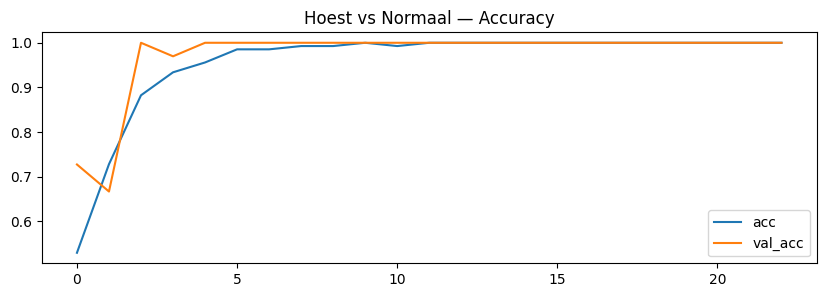

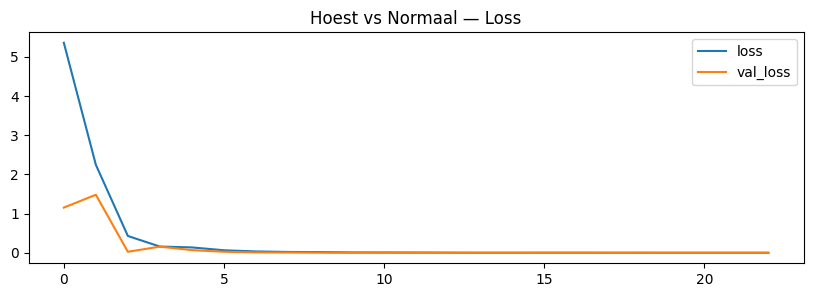

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
              precision    recall  f1-score   support

       Hoest      1.000     1.000     1.000        11
     Normaal      1.000     1.000     1.000        22

    accuracy                          1.000        33
   macro avg      1.000     1.000     1.000        33
weighted avg      1.000     1.000     1.000        33



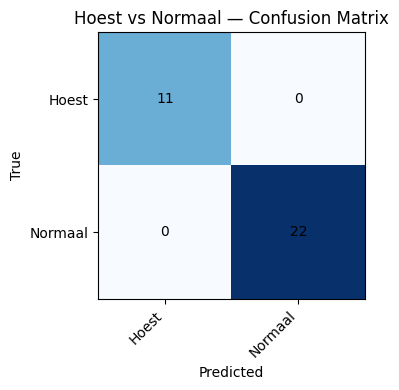


EXPERIMENT: Hoest vs Hart  —  Klassen: Hoest vs Hart
Klassen (encoded): [np.str_('Hart'), np.str_('Hoest')]
X shape: (254, 513, 184, 1) y shape: (254,)
Train: (204, 513, 184, 1) Val: (50, 513, 184, 1)
Class balance (train): [160  44]
Class balance (val)  : [40 10]
Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step - accuracy: 0.6618 - loss: 5.1728 - val_accuracy: 0.9000 - val_loss: 0.3746 - learning_rate: 0.0010
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - accuracy: 0.9216 - loss: 0.4036 - val_accuracy: 0.9400 - val_loss: 0.1245 - learning_rate: 0.0010
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - accuracy: 0.9853 - loss: 0.0554 - val_accuracy: 0.9200 - val_loss: 0.1873 - learning_rate: 0.0010
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - accuracy: 0.9902 - loss: 0.0531 - val_accuracy: 0.9400 - val_loss: 0.0967 - learning_rate: 0.0010
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - accuracy: 1.0000 - loss: 0.0309 - val_accuracy: 0.9400 - val_loss: 0.1053 - learni

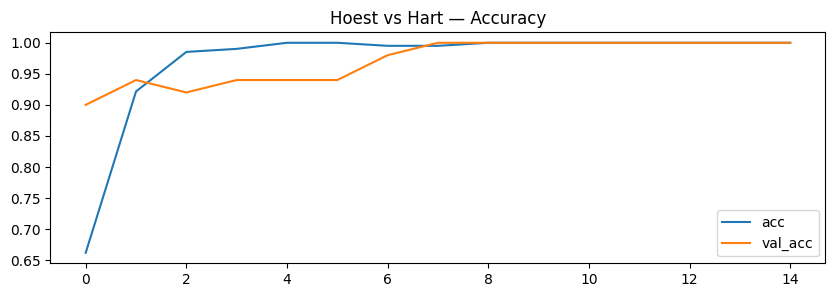

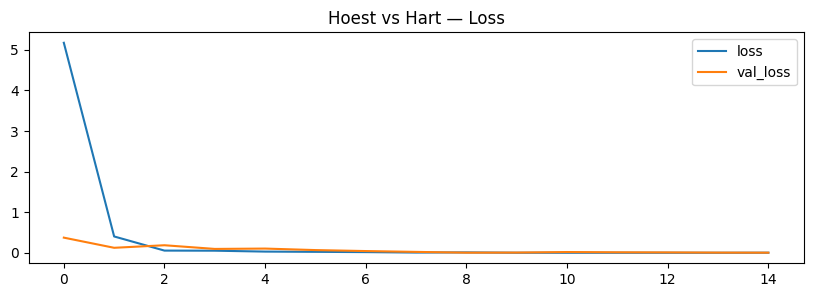

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
              precision    recall  f1-score   support

        Hart      1.000     1.000     1.000        40
       Hoest      1.000     1.000     1.000        10

    accuracy                          1.000        50
   macro avg      1.000     1.000     1.000        50
weighted avg      1.000     1.000     1.000        50



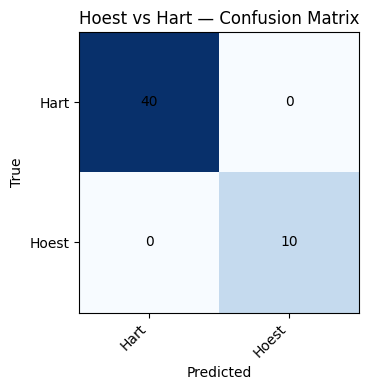


EXPERIMENT: Normaal vs Hart  —  Klassen: Normaal vs Hart
Klassen (encoded): [np.str_('Hart'), np.str_('Normaal')]
X shape: (315, 513, 184, 1) y shape: (315,)
Train: (235, 513, 184, 1) Val: (80, 513, 184, 1)
Class balance (train): [140  95]
Class balance (val)  : [60 20]
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 310ms/step - accuracy: 0.5362 - loss: 8.9784 - val_accuracy: 0.7500 - val_loss: 2.1328 - learning_rate: 0.0010
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - accuracy: 0.5574 - loss: 2.2693 - val_accuracy: 0.2500 - val_loss: 2.9860 - learning_rate: 0.0010
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - accuracy: 0.5106 - loss: 1.1427 - val_accuracy: 0.7875 - val_loss: 0.4525 - learning_rate: 0.0010
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step - accuracy: 0.6553 - loss: 0.6087 - val_accuracy: 0.6250 - val_loss: 0.6263 - learning_rate: 0.0010
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - accuracy: 0.6766 - loss: 0.5972 - val_accuracy: 0.7000 - val_loss: 0.5357 - 

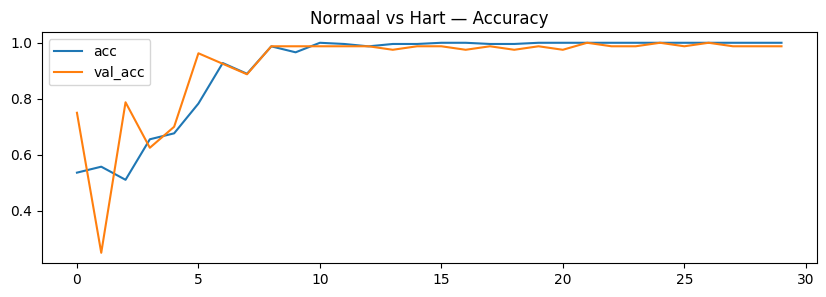

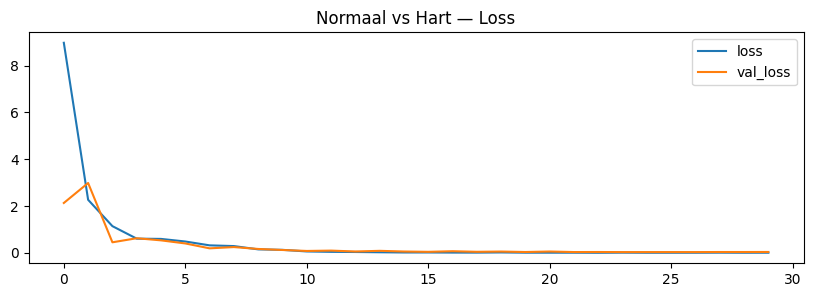

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
              precision    recall  f1-score   support

        Hart      0.984     1.000     0.992        60
     Normaal      1.000     0.950     0.974        20

    accuracy                          0.988        80
   macro avg      0.992     0.975     0.983        80
weighted avg      0.988     0.988     0.987        80



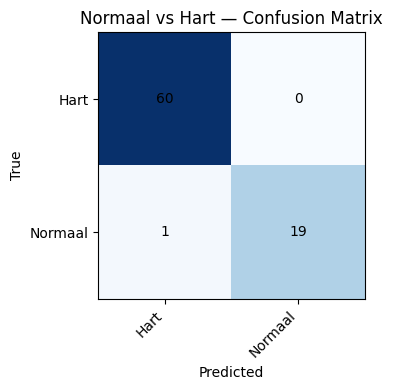

In [71]:
# 5) Draai alle drie de experimenten
for exp_title, pair in experiments:
    run_experiment(exp_title, pair)